<a href="https://colab.research.google.com/github/Servat0r/Robotics-Project/blob/master/finetunedVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fine-tuned VGG16

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [ ]:
%run utils.ipynb

In [ ]:
images, tip_pos = get_dataset(target_size=(224, 224), force_resize=False, rescale_coordinates=100)

In [ ]:
(train_images, train_tip_pos), (eval_images, eval_tip_pos), (test_images, test_tip_pos) = \
  holdout_split(0.6, 0.2, 0.2, images, tip_pos)

In [ ]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

(513, 224, 224, 3) float32


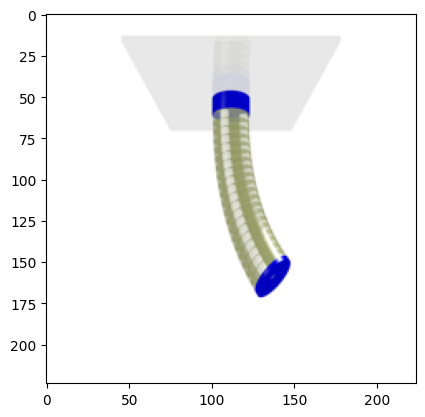

In [ ]:
print(images.shape, images.dtype)
plt.imshow(PIL.Image.fromarray((255 * images[12]).astype(np.uint8)))

In [ ]:
del images

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
13/13 [==============================] - 14s 619ms/step - loss: 56.7416 - mean_absolute_error: 6.0281 - mean_euclidean_error: 12.0283 - val_loss: 30.6120 - val_mean_absolute_error: 4.4005 - val_mean_euclidean_error: 8.8478
Epoch 2/100
13/13 [==============================] - 2s 181ms/step - loss: 18.1690 - mean_absolute_error: 3.2585 - mean_euclidean_error: 6.6907 - val_loss: 15.0419 - val_mean_absolute_error: 3.1246 - val_mean_euclidean_error: 6.4334
Epoch 3/100
13/13 [==============================] - 2s 175ms/step - loss: 9.7731 - mean_absolute_error: 2.3125 - mean_euclidean_error: 4.8882 - val_loss: 7.8315 - val_mean_absolute_error: 2.1056 - val_mean_euclidean_error: 4.3994
Epoch 4/100
13/13 [==============================] - 2s 177ms/step - loss: 5.5025 - mean_absolute_error: 1.6539 - mean_euclidean_error: 3.5001 - val_loss: 4.3184 - val_mean_absolute_error: 1.4505 - val_mean_euclidean_error: 3.1225
Epoch 5/100
13/13 [==============================] - 2s 158ms/step - l

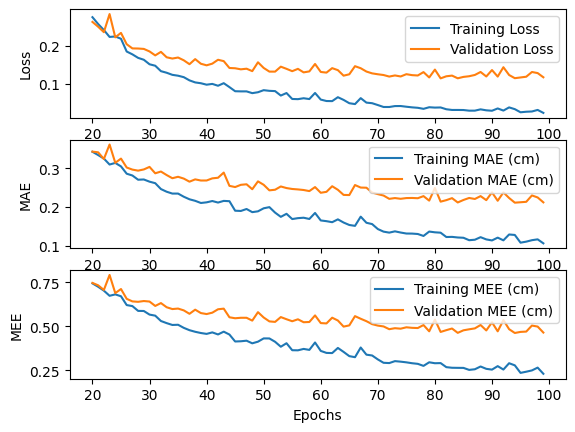

In [ ]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

4/4 [==============================] - 1s 136ms/step
103 103 103
102 102 103


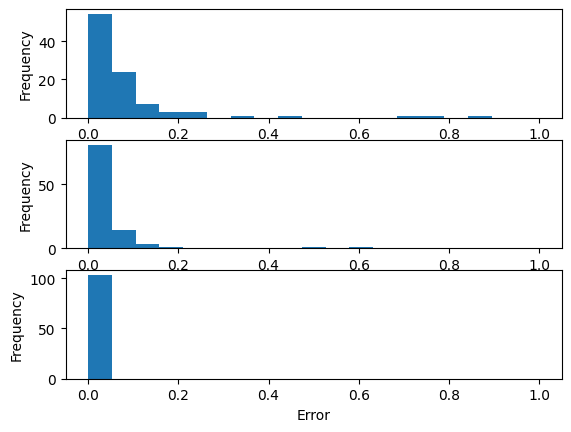

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

4/4 [==============================] - 0s 18ms/step
103 103 103
102 102 103


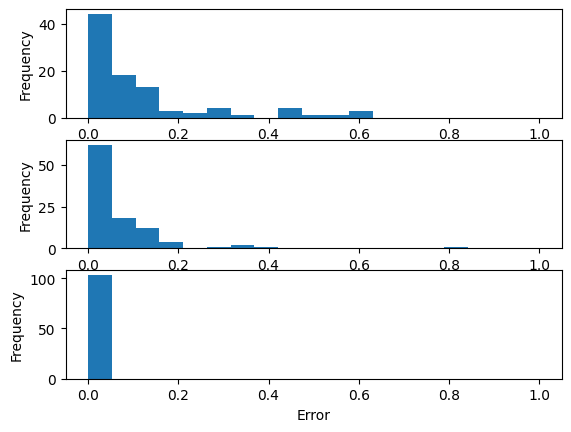

In [ ]:
epsilon = 1e-8
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Now we save model and history:

In [ ]:
model.save('finetunedVGG')

In [ ]:
del model

In [ ]:
json.dump(history.history, open('finetunedVGG.json', 'w'))

### Fine-tuned VGG19